## Installing package dependencies

In [ ]:
# install the necessary libraries
!pip install datasets transformers torch torchvision faiss-cpu
!pip install gptq
!pip install accelerate
!pip install -U bitsandbytes
!pip install peft
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps packaging ninja einops flash-attn xformers trl peft accelerate bitsandbytes

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-lmbypg_4/unsloth_c61a73e97e584bc09c3de55103885781
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-lmbypg_4/unsloth_c61a73e97e584bc09c3de55103885781
  Resolved https://github.com/unslothai/unsloth.git to commit a100afa60cf1566e784b41eb462b5d2ed80977f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


## Import the required packages

In [ ]:
## import packages
from datasets import load_dataset
import torch
from transformers import CLIPProcessor, CLIPModel, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM, AutoTokenizer, AutoModelForCausalLM, BloomForCausalLM
import faiss
from PIL import Image
import io
import numpy as np
from gptq import GPTQ
from accelerate import init_empty_weights, load_checkpoint_and_dispatch
from bitsandbytes.functional import quantize_blockwise, dequantize_blockwise
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoModelForCausalLM
from accelerate import cpu_offload
from peft import PeftModel, get_peft_model
from unsloth import FastLanguageModel

## Section 1

### Vector Database creation

Dataset Link: https://huggingface.co/datasets/nateraw/pascal-voc-2012



In [ ]:
# Load the dataset
dataset = load_dataset("nateraw/pascal-voc-2012", split="train")

In [ ]:
def create_and_store(dataset):
    # Preprocess the images
    def preprocess_image(example):
        # Get the image from the example
        image = example['image']
        # Convert the image to RGB format if it's not already in RGB
        if image.mode != "RGB":
            image = image.convert("RGB")
        return image

    # Apply the preprocess_image function to each example in the dataset
    dataset = dataset.map(lambda example: {'image': preprocess_image(example)})

    # Load the CLIP model and processor
    model_name = "openai/clip-vit-base-patch32"
    model = CLIPModel.from_pretrained(model_name)
    processor = CLIPProcessor.from_pretrained(model_name)

    # Extract image features using CLIP
    def extract_features(examples):
        # Process the images using the CLIP processor
        inputs = processor(images=examples['image'], return_tensors="pt")
        # Extract image features using the CLIP model
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
        # Return the image features as a numpy array
        return {'image_features': image_features.cpu().detach().numpy()}

    # Apply the extract_features function to the dataset in batches
    dataset = dataset.map(extract_features, batched=True, batch_size=16)

    # Build the vector database using FAISS
    d = 512  # dimensionality of image features
    index = faiss.IndexFlatL2(d)

    # Concatenate all image features into a single numpy array
    all_features = np.concatenate(dataset['image_features'])
    # Reshape the features to (n_samples, feature_dim)
    all_features = np.reshape(all_features, (-1, d))
    # Add the image features to the FAISS index
    index.add(all_features)

    return index

# Create and store the vector database
embeddings = create_and_store(dataset)

## Section 2

Implement search functionlity

<ipython-input-6-58def82495a2>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_image = dataset[int(idx)]['image']


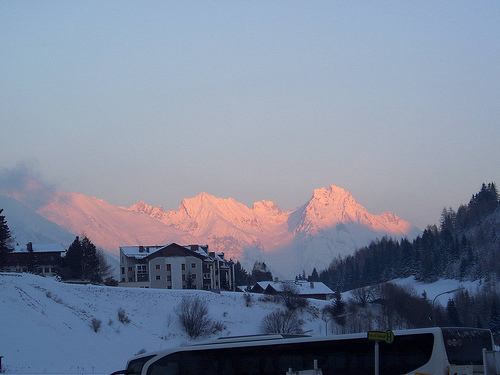

In [ ]:
def search(input_query, vectorDB, dataset):
    # Load the CLIP model and processor
    model_name = "openai/clip-vit-base-patch32"
    model = CLIPModel.from_pretrained(model_name)
    processor = CLIPProcessor.from_pretrained(model_name)

    # Perform search
    # Process the input query using the CLIP processor
    inputs = processor(text=[input_query], return_tensors="pt")
    # Extract text features using the CLIP model
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)

    # Convert text features to numpy array
    text_features = text_features.cpu().detach().numpy()

    # Set the number of top matches to retrieve
    top_k = 1
    # Perform similarity search using FAISS
    distances, indices = vectorDB.search(text_features, top_k)

    # Retrieve the relevant image
    # Get the index of the closest match
    idx = indices[0]
    # Retrieve the corresponding image from the dataset
    output_image = dataset[int(idx)]['image']

    return output_image

# Load vectorDB
filename = 'VectoDB file name'  # Not used in this case
vectorDB = embeddings

# Example usage of search function
input_query = 'a scenic view of a mountain landscape'
output_image = search(input_query, vectorDB, dataset)
output_image

## Section 3

LLM output

In [ ]:
# Load the LLM model and tokenizer
lm_model_name = "unsloth/mistral-7b-instruct-v0.1-bnb-4bit"
tokenizer = AutoTokenizer.from_pretrained(lm_model_name)

# Load the model with the desired configuration
model, _ = FastLanguageModel.from_pretrained(
    lm_model_name,
    device_map="auto",
    load_in_4bit=True,
    dtype=torch.float16,
)

def generate_entity_descriptions(model, tokenizer, input_query, prompt, max_length=150):
    # Combine the input query and prompt
    full_query = f"{prompt}\n\nInput: {input_query}\n\nOutput:"

    # Tokenize the full query
    input_ids = tokenizer.encode(full_query, return_tensors="pt")

    # Create attention mask
    attention_mask = torch.ones_like(input_ids)

    # Set the pad token ID
    pad_token_id = tokenizer.eos_token_id

    # Generate the entity descriptions using the model
    with torch.no_grad():
        output = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_return_sequences=1,
            pad_token_id=pad_token_id
        )

    # Decode the generated output
    output_text = tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract the generated entity descriptions
    entity_descriptions = output_text.split("Output:")[-1].strip()

    return entity_descriptions

# Use the same input query as in Section 2
input_query = 'a scenic view of a mountain landscape'

# Define the prompt
prompt = '''Given a natural language query, identify the key entities mentioned and provide a concise description for each entity.

Now, generate descriptions for the entities in the following input query.'''

# Generate the entity descriptions using the model
output_text = generate_entity_descriptions(model, tokenizer, input_query, prompt)

# Print the generated entity descriptions
print("Generated Entity Descriptions:")
print(output_text)


==((====))==  Unsloth: Fast Mistral patching release 2024.3
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Generated Entity Descriptions:
- Scenic view: A visually pleasing and picturesque view of a natural environment.
- Mountain landscape: A natural environment featuring mountainous terrain and possibly other natural features such as forests, rivers, and lakes.
